## Wyjaśnialne uczenie maszynowe - PD8
### Wojciech Celej

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import AffinityPropagation

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import ruptures as rpt

### 1. Wybór zbioru danych

1. Zbiór danych pochodzi z https://www.openml.org/.  
1. Opis zbioru danych:  
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air',  
J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch,  
'Regression diagnostics ...', Wiley, 1980. N.B. Various transformations are used in the table on pages 244-261 of the latter.  
1. Variables in order:
    * CRIM per capita crime rate by town 
    * ZN proportion of residential land zoned for lots over 25,000 sq.ft. 
    * INDUS proportion of non-retail business acres per town 
    * CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
    * NOX nitric oxides concentration (parts per 10 million) 
    * RM average number of rooms per dwelling 
    * AGE proportion of owner-occupied units built prior to 1940 DIS weighted distances to five Boston employment centres 
    * RAD index of accessibility to radial highways 
    * TAX full-value property-tax rate per \$10,000 
    * PTRATIO pupil-teacher ratio by town B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
    * LSTAT \% lower status of the population MEDV Median value of owner-occupied homes in \$ 1000's



In [2]:
boston_data = pd.read_csv("boston.csv")
X = boston_data.drop(columns="MEDV")
y = boston_data["MEDV"]
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


Podział na zmienne numeryczne i kategoryczne

In [3]:
categorical_columns = {"RAD", "CHAS"}
numerical_columns = set(X.columns) - categorical_columns
numerical_columns

{'AGE',
 'B',
 'CRIM',
 'DIS',
 'INDUS',
 'LSTAT',
 'NOX',
 'PTRATIO',
 'RM',
 'TAX',
 'ZN'}

Wyodrębnienie zbioru testowego

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

### 2. Budowa modeli Random Forest i LGBM

#### LightGBM

In [5]:
warnings.filterwarnings('ignore')
lgb_model = lgb.LGBMRegressor(learning_rate=0.05, n_estimators=1000)
fit_params = {
    "eval_set": (X_test, y_test), 
    "early_stopping_rounds": 20, 
    "verbose": 0, 
    "categorical_feature": categorical_columns
}
lgb_model.fit(X_train, y_train, **fit_params)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [6]:
warnings.filterwarnings('ignore')
lgb_data = lgb.Dataset(data=X_train.values, label=y_train.values)
cv = lgb.cv(
    params=lgb_model.get_params(),
    train_set=lgb_data,
    nfold=5,
    metrics="mean_squared_error",
    early_stopping_rounds=20,
    stratified=False
)

Wyniki uzskane 5-krotną CV

In [7]:
pd.DataFrame(cv).iloc[-1, :]

l2-mean    14.524776
l2-stdv     6.069930
Name: 167, dtype: float64

Wyniki na zbiorze testowym

In [8]:
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mse_lgb

10.028883306682442

#### Random Forest

In [9]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=100, verbose=0,
                      warm_start=False)

Wyniki uzskane 5-krotną CV

In [10]:
results_rf = abs(cross_validate(rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)["test_score"])
results_rf.mean(), results_rf.std()

(12.534139119290117, 3.892287138949927)

Wyniki na zbiorze testowym

In [11]:
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf

9.91272163970587

### 3. Wybór lepszego modelu

Lepsze rezultaty na zbiorze testowym oraz stosując 5-krotną CV na zbiorze treningowym uzyskano dla `Random Forest`, więc to ten model wybrano do wyznaczenia krzywych PDP i podziału zmiennych.

#### Przekształcenie zmiennych numerycznych

In [12]:
def plot_dp(model, df, feature, nPoints):
    plt.figure(figsize=(10,5))
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    for index, row in df.iterrows():
        sample = pd.DataFrame(columns=row.index)
        sample.loc[0] = row.values
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict(samples)
        y_cum.append(y)
    y_cum = np.array(y_cum).mean(axis=0)
    plt.plot(x, y_cum, color="navy", linewidth=2)
    plt.ylabel("Regression reults")
    plt.title(f"PDP for {feature}")
    plt.grid(True)
    return x, y_cum

def plot_dp_and_breaks(model, X_train, numerical_features, nPoints):
    breaks_dict = {}
    for feature in numerical_features:
        x, signal = plot_dp(lgb_model, X_train, feature, 100)
        algo = rpt.Pelt(model="l1").fit(signal)
        result = algo.predict(pen=0.5)
        breaks = []
        for i in range(len(result)-1):
            x_break = (x[result[i]-1] + x[result[i]])/2
            plt.axvline(x_break, color="darkred", linestyle = "--")
            breaks.append(x_break)
        plt.show()
        breaks_dict[feature] = breaks
    return breaks_dict

Poniżej przedstawione są linie podziałów odpowiednich zmiennych numerycznych na zmienne jakościowe (czerwone przerywane linie oznaczają granicę podziału). Podziały są tworzone w oparciu o zbiór uczący.

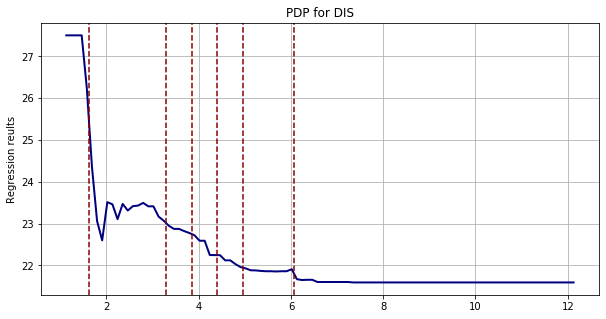

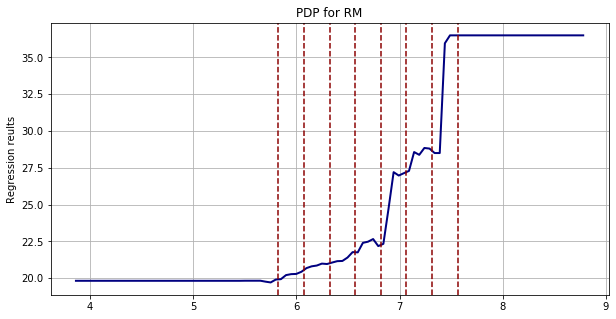

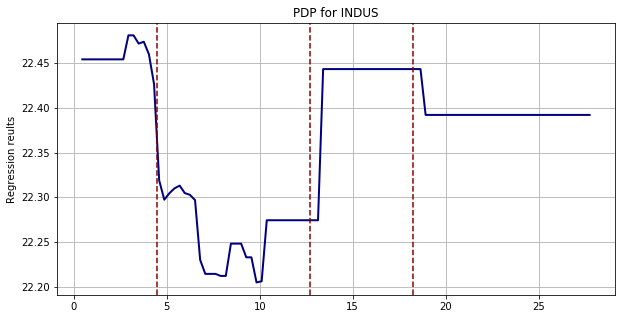

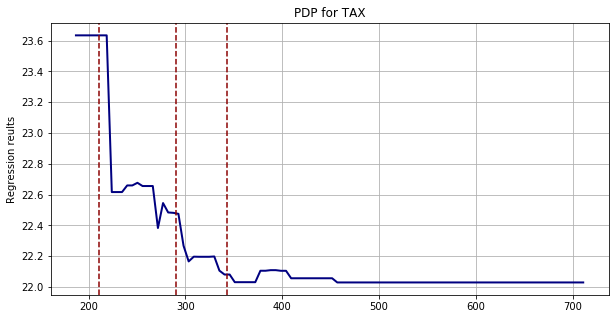

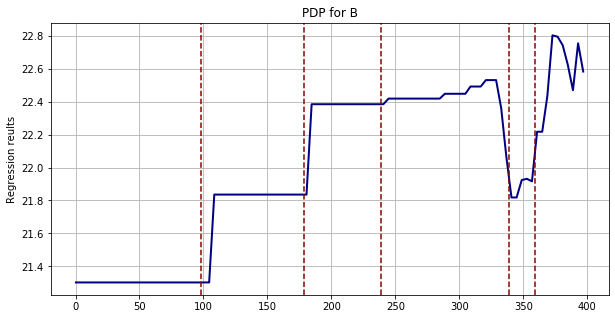

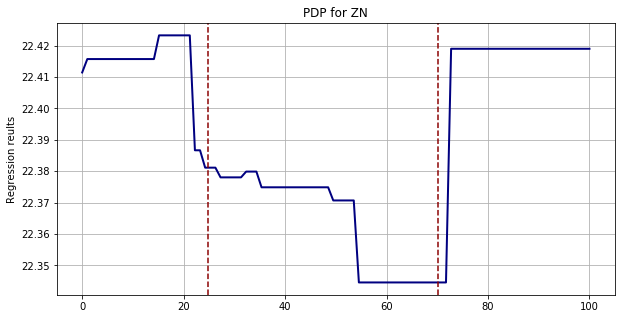

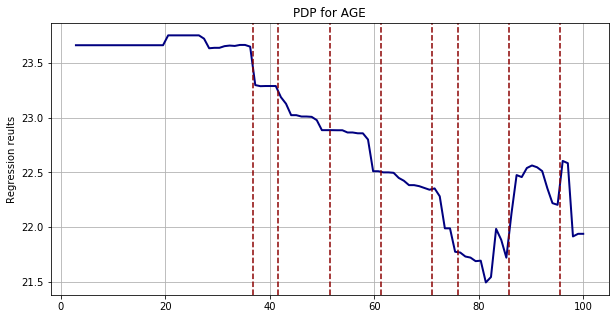

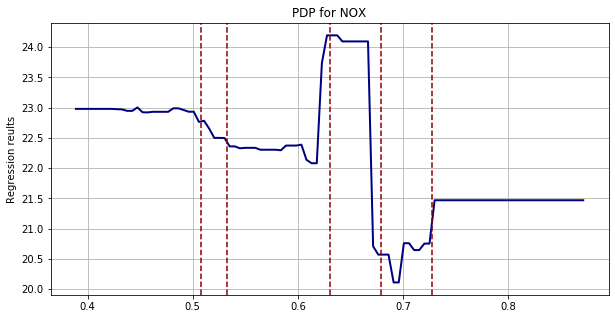

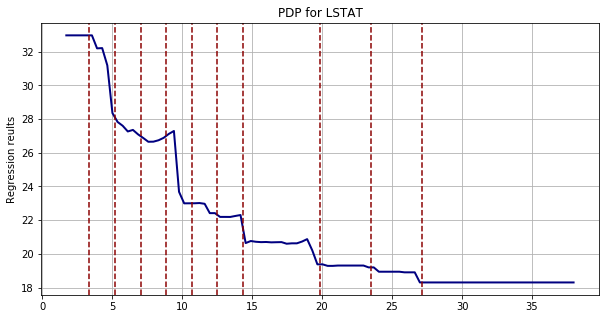

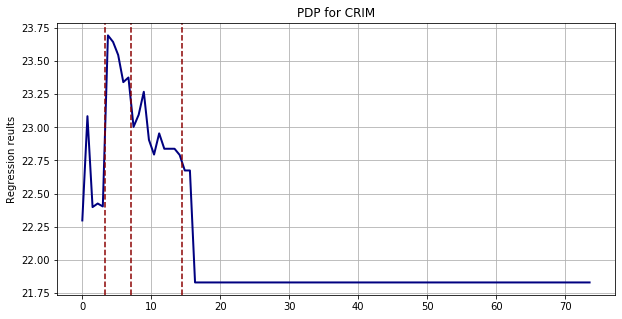

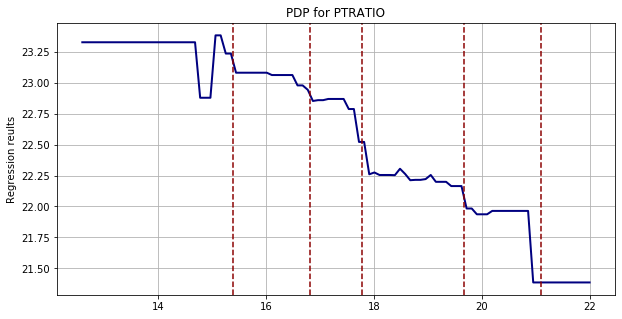

In [13]:
breaks_dict = plot_dp_and_breaks(rf_model, X_train, numerical_columns, 100)

In [14]:
def transform_column(x, breaks):
    for it, value in enumerate(breaks):
        if x <= value:
            return it
    return len(breaks)

def transform_numerical_features(X_train, breaks_dict):
    X_new = X_train.copy()
    numerical_columns = breaks_dict.keys()
    for feature, breaks in breaks_dict.items():
        X_new[feature] = X_train[feature].apply(transform_column, breaks=breaks_dict[feature])
    return X_new

Przekształcenie zmiennych na zbiorze treningowym i testowym.

In [15]:
X_train_trans = transform_numerical_features(X_train, breaks_dict)
X_test_trans = transform_numerical_features(X_test, breaks_dict)

#### Przekształcenie zmiennej kategorycznej "RAD"

Zmienna kategoryczna `CHAS` zawiera 2 kategorie, więc wystarczy zająć się zmienną RAD. Poniżej przedstawiono liczności poszczególnych kategorii:

In [16]:
X_train["RAD"].value_counts()

24    107
5      93
4      87
3      33
6      22
8      19
2      19
1      13
7      11
Name: RAD, dtype: int64

In [17]:
X_test["RAD"].value_counts()

24    25
4     23
5     22
1      7
7      6
8      5
3      5
2      5
6      4
Name: RAD, dtype: int64

Funkcja poniżej rysuje rozkład średnich odpowiedzi modelu RF w poszczególnych kategoriach zmiennej `RAD`. Na ich podstawie, stosując algorytm `AffinityPropagation` dokonuje segmentacji na nowe klasy (kolory słupków oznaczają nowe klasy po segmentacji).

In [18]:
def transform_cat_feature(X_train, X_test, feature, predictions):
    X_new_train = X_train.copy()
    X_new_test = X_test.copy()
    label_encoder = LabelEncoder()
    label_encoder.fit(X_train[feature].sort_values())
    X_new_train[feature] = label_encoder.transform(X_train[feature])
    X_new_test[feature] = label_encoder.transform(X_test[feature])
    
    X_new_train["y_pred"] = predictions

    feature_means = X_new_train.groupby(feature)[["y_pred"]].mean().reset_index()
    
    ap_cluster = AffinityPropagation()
    ap_cluster.fit(feature_means[["y_pred"]].values)
    feature_means["transformed_feature"] = ap_cluster.predict(feature_means[["y_pred"]].values)
    
    sns.set(rc={'figure.figsize':(10,6)})
    sns.barplot(data=feature_means, x=feature, y="y_pred", hue="transformed_feature", palette="Paired", dodge=False)
    plt.legend(title="Clustered label")
    plt.show()
    
    X_new_train = X_new_train.drop(columns=["y_pred"])
    mapper = dict([(key, value) for key, value in zip(feature_means[feature], feature_means["transformed_feature"])])
    X_new_train[feature] = X_new_train[feature].map(mapper)
    X_new_test[feature] = X_new_test[feature].map(mapper)
    
    return X_new_train, X_new_test

In [19]:
predictions = rf_model.predict(X_train)

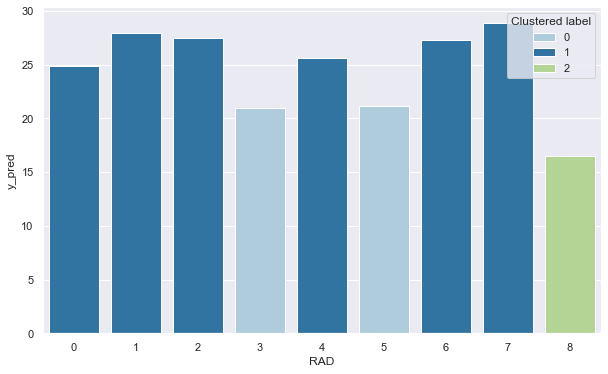

In [20]:
X_train_trans, X_test_trans = transform_cat_feature(X_train_trans, X_test_trans, "RAD", predictions)

### 4. Prosty model - Regresja Liniowa

In [21]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_trans, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
y_pred_lin_reg_t = lin_reg_model.predict(X_test_trans)
mse_lin_t = mean_squared_error(y_test, y_pred_lin_reg_t)
mse_lin_t

20.601450473633168

### 5. Porównanie grup modeli

#### Regresja Liniowa przed transformacją

In [23]:
lin_reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
y_pred_lin_reg = lin_reg_model.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin_reg)
mse_lin

23.066428424068103

#### LightGBM po transformacji

In [25]:
lgb_model.fit(X_train_trans, y_train, categorical_feature=list(X_train_trans.columns))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
y_pred_lgb_t = lgb_model.predict(X_test_trans)
mse_lgb_t = mean_squared_error(y_test, y_pred_lgb_t)
mse_lgb_t

15.893553704476428

#### Random Forest po transformacji

In [27]:
rf_model.fit(X_train_trans, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=100, verbose=0,
                      warm_start=False)

In [28]:
y_pred_rf_t = rf_model.predict(X_test_trans)
mse_rf_t = mean_squared_error(y_test, y_pred_rf_t)
mse_rf_t

13.011562705004394

#### Tabela porównująca modele

In [29]:
data = {
    "Model": np.repeat(["RandomForest", "LightGBM", "LinearRegression"], 2),
    "Data": ["raw", "transformed"] * 3,
    "MSE": [mse_rf, mse_rf_t, mse_lgb, mse_lgb_t, mse_lin, mse_lin_t]
}

In [30]:
results = pd.DataFrame(data=data)
results

,Model,Data,MSE
0,RandomForest,raw,9.912722
1,RandomForest,transformed,13.011563
2,LightGBM,raw,10.028883
3,LightGBM,transformed,15.893554
4,LinearRegression,raw,23.066428
5,LinearRegression,transformed,20.601450


#### Wykres porównujący modele

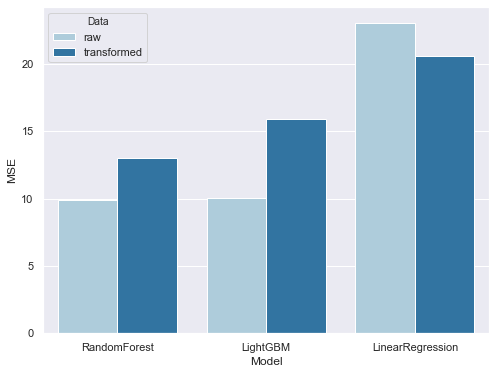

In [31]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=results, x="Model", y="MSE", hue="Data", palette="Paired")
plt.show()

#### Wnioski

* Dla złożonych modeli black-box transformacja zmiennych pogorszyła wyniki modelu na zbiorze testowym
* Dla prostego modelu jakim jest Regresja Liniowa transformacja zmiennych przyniosła poprawę rezultatów
* Wyniki dla modeli typu black-box niezależnie od operacji na danych są lepsze od modelu white-box nawet dla danych po transformacji - to co uzyskano to łatwość intepretacji modelu typu white-box